# Machine Learning Project:
# Wallstreetbets Sentiment Analysis

## Prep

In [109]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
import re


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# To make stable across runs
np.random.seed(123)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
# Import data
df = pd.read_csv('data/reddit_wsb.csv')

## Data Exploration

### Feature explanations
> - Title: The title of the Reddit post.
> - Score: The Reddit score associated with the post, indicating the number of upvotes minus the number of downvotes (post's popularity).
> - Id: The unique identifier for each post.
> - Url: The URL of the post.
> - Comms_num: The number of comments on the post (engagement).
> - Created: The timestamp, expressed in epoch time format, of when the post was created.
> - Body: The text content of the post.
> - Timestamp: The timestamp of when the post was created.

In [52]:
df_explore = df.copy()
df_explore = df_explore[['title','body','score','timestamp']]

In [53]:
df_explore.sample(5, random_state=0)

,title,body,score,timestamp
22805,'This is real' — Mark Cuban says Reddit trader...,NaN,6938,2021-02-03 03:18:10
42768,"You’re buying based on gut feeling, selling on...",**Not a trading advise.**\n\nHey there folks a...,4985,2021-03-22 11:34:22
45313,"Anyone remember my 4/23C at 4,200? 5/7C and al...",NaN,33,2021-04-14 01:55:40
26051,Losing more and more . Picture is how i feel b...,NaN,58,2021-02-04 14:03:33
42227,"$TR Tootsie Roll, $AMC and stimmi. Throw in a ...",NaN,45,2021-03-18 02:56:09


In [55]:
# To understand how big the file is and how many variables it has
print('This dataframe has' ,df_explore.shape[0], 'rows and', df_explore.shape[1], 'columns')

This dataframe has 53187 rows and 4 columns


In [54]:
df_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53187 entries, 0 to 53186
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      53187 non-null  object
 1   body       24738 non-null  object
 2   score      53187 non-null  int64 
 3   timestamp  53187 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.6+ MB


- We can see that more of 50% of the 'body' feature are NULL
- Dates range are from January 28th, 2021 to August 2nd, 2021. Seven months of data.

In [56]:
# Function to visualize the word cloud and word frequency for a given feature

def word_cloud(text_feature, title_or_body):
    titles = text_feature

    # Combining all titles into a single string
    all_titles = ' '.join(titles)

    # Tokenizing the text (process of breaking down a text into individual units)
    tokens = word_tokenize(all_titles)

    # Removing stopwords
    stop_words = set(stopwords.words('english')) # Creates a set of common English stop words (ex: 'and', 'to') 
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.isalpha()]

    # Word cloud
    word_cloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_tokens))

    # Word Cloud plot
    plt.figure(figsize=(10, 4))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
   # Analyze Word Frequency
    word_freq = Counter(filtered_tokens)
    df_explore_word_freq = pd.DataFrame(list(word_freq.items()), columns=['Word', 'Frequency'])
    df_explore_word_freq = df_explore_word_freq.sort_values(by='Frequency', ascending=False)

    # Plot the top N words by frequency
    top_n = 15
    plt.figure(figsize=(15, 4))
    plt.bar(df_explore_word_freq['Word'][:top_n], df_explore_word_freq['Frequency'][:top_n], color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Words in {title_or_body}')
    plt.show()

**`Feature title`**
> Let's see what words/stocks are the most common 

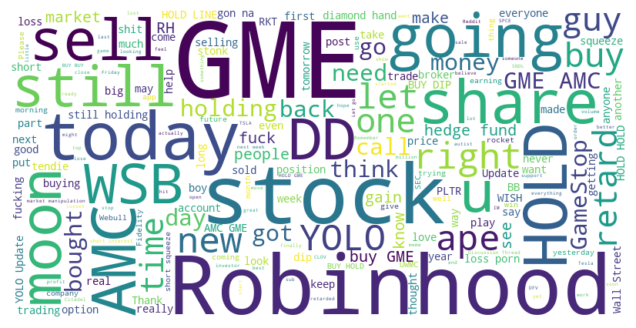

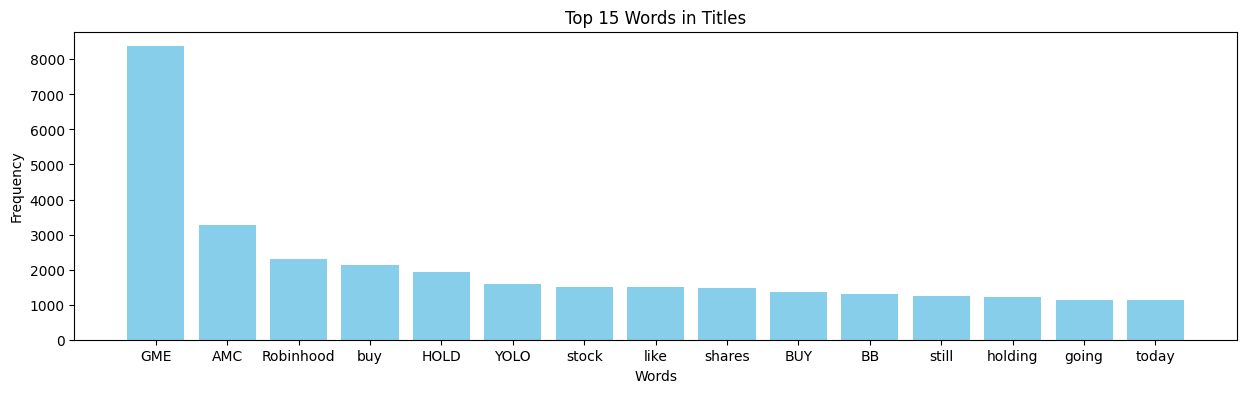

In [57]:
word_cloud(df_explore['title'], 'Titles')

**`Feature body`**
> We are going to repeat here the same exercise that we did for the feature 'title', to catch the words/stocks that are more frequent

In [58]:
print('\033[1mThere are', df_explore['body'].isnull().sum(), 'nulls in the "body" column')

There are 28449 nulls in the "body" column


In [59]:
# We are going to use only the observations with texts in the 'body' column
df_body = df_explore[df_explore['body'].notnull()]
df_body.head(2)

,title,body,score,timestamp
2,Exit the system,The CEO of NASDAQ pushed to halt trading “to g...,0,2021-01-28 21:30:35
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,Hedgefund whales are spreading disinfo saying ...,317,2021-01-28 21:26:27


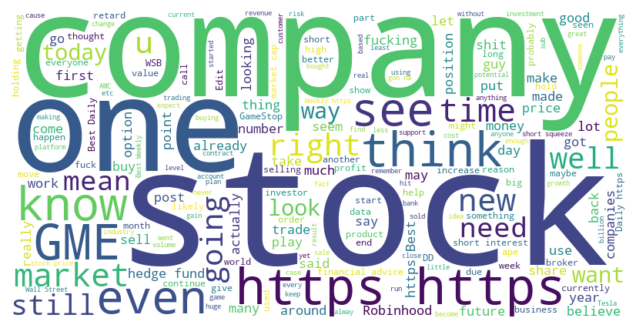

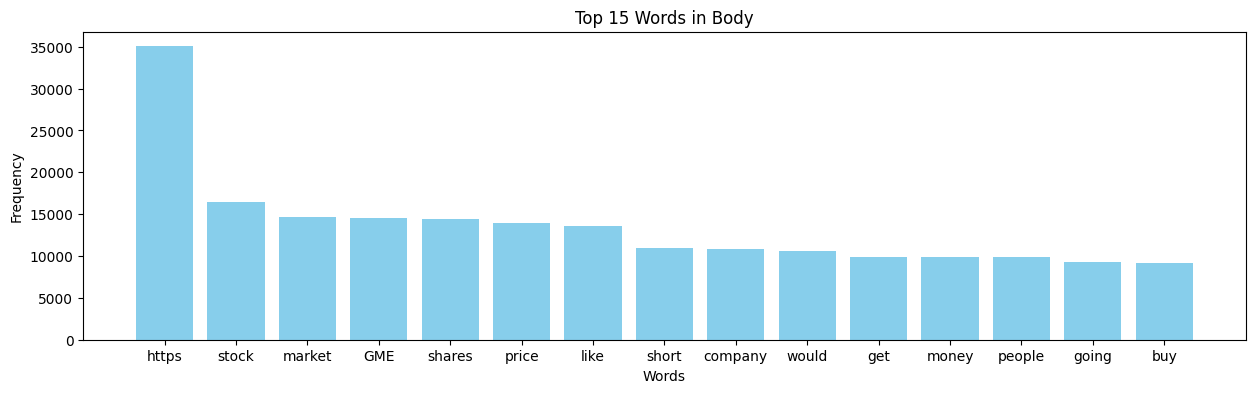

In [60]:
word_cloud(df_body['body'], 'Body')

**`Feature Score`**

In [61]:
df_explore['score'].unique()

array([   55,   110,     0, ...,  2997, 45436,  7398], dtype=int64)

In [62]:
# Looking for negative values
df_explore[(df_explore['score'] <0)].sum()

title        0
body         0
score        0
timestamp    0
dtype: object

In [63]:
df_explore['score'].describe()

count     53187.000000
mean       1382.461053
std        7999.271074
min           0.000000
25%           2.000000
50%          37.000000
75%         207.000000
max      348241.000000
Name: score, dtype: float64

In [64]:
# Post with highest score
df_explore[df_explore['score']==348241]

,title,body,score,timestamp
19162,Times Square right now,NaN,348241,2021-01-31 04:00:38


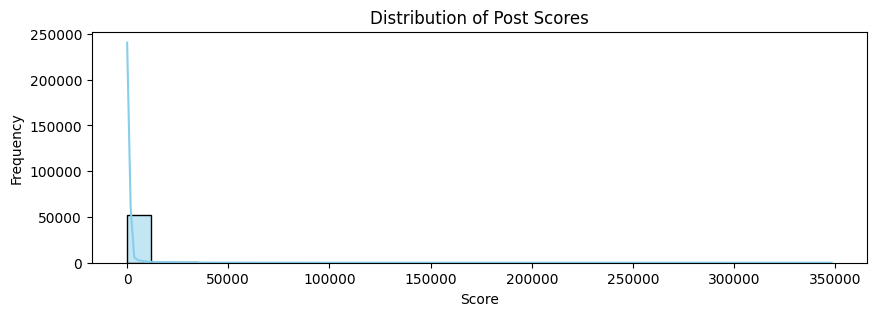

In [65]:
# Distribution plot for 'score'
plt.figure(figsize=(10, 3))
sns.histplot(df_explore['score'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Post Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

> We can see that lower scores are more frequent. Besides that, feature "scores" alone does not give much more information. We will try to find more insights by using the stock symbols that are more frequent in both columns, "title" and "body," and aggregating the data by date.

In [66]:
df_explore['body'] = df_explore['body'].fillna("")

### Stock Symbols

In [67]:
# Stock symbols that appear most often
stocks = ['GME', 'AMC']

# Additional variations to include
additional_variations = {'GME': ['Gamestop'], 'AMC': []}

# Columns to search for stock symbols
columns = ['title', 'body']

# Regular expressions for different variations of stock symbols
patterns = [r'\b{}\b'.format(re.escape(stock)) for stock in stocks]

# Include additional variations in the patterns
for stock, variations in additional_variations.items():
    patterns += [r'\b{}\b'.format(re.escape(variation)) for variation in variations]

# New column 'stock_symbols'
df_explore['stock_symbols'] = df_explore[columns].apply(lambda row: [stock for stock, pattern in zip(stocks, patterns) if any(re.search(pattern, cell, flags=re.I) for cell in row)], axis=1)

df_explore.head()

,title,body,score,timestamp,stock_symbols
0,"It's not about the money, it's about sending a...",,55,2021-01-28 21:37:41,[]
1,Math Professor Scott Steiner says the numbers ...,,110,2021-01-28 21:32:10,[]
2,Exit the system,The CEO of NASDAQ pushed to halt trading “to g...,0,2021-01-28 21:30:35,[GME]
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,,29,2021-01-28 21:28:57,[GME]
4,"Not to distract from GME, just thought our AMC...",,71,2021-01-28 21:26:56,"[GME, AMC]"


In [68]:
# Convert timestamp to datetime
df_explore['timestamp'] = pd.to_datetime(df_explore['timestamp'])

In [100]:
# Filter rows where GME or AMC is mentioned
gme_rows = df_explore[df_explore['stock_symbols'].apply(lambda symbols: 'GME' in symbols)]
amc_rows = df_explore[df_explore['stock_symbols'].apply(lambda symbols: 'AMC' in symbols)]

# Group by date and count the number of posts for each day
gme_counts = gme_rows.groupby(gme_rows['timestamp'].dt.date).size()
amc_counts = amc_rows.groupby(amc_rows['timestamp'].dt.date).size()

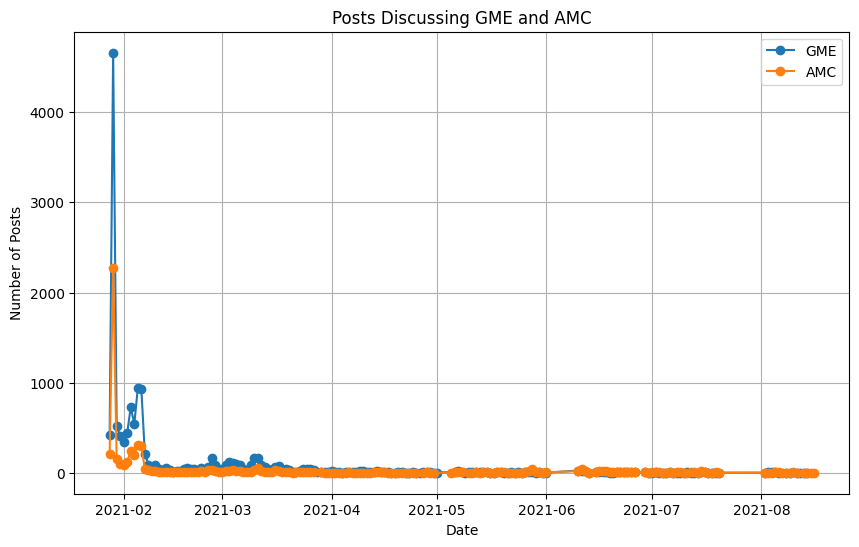

In [101]:
# Plot discussions about GME and AMC through the year
plt.figure(figsize=(10, 6))
plt.plot(gme_counts.index, gme_counts.values, label='GME', marker='o')
plt.plot(amc_counts.index, amc_counts.values, label='AMC', marker='o')

plt.title('Posts Discussing GME and AMC')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend()
plt.grid(True)
plt.show()

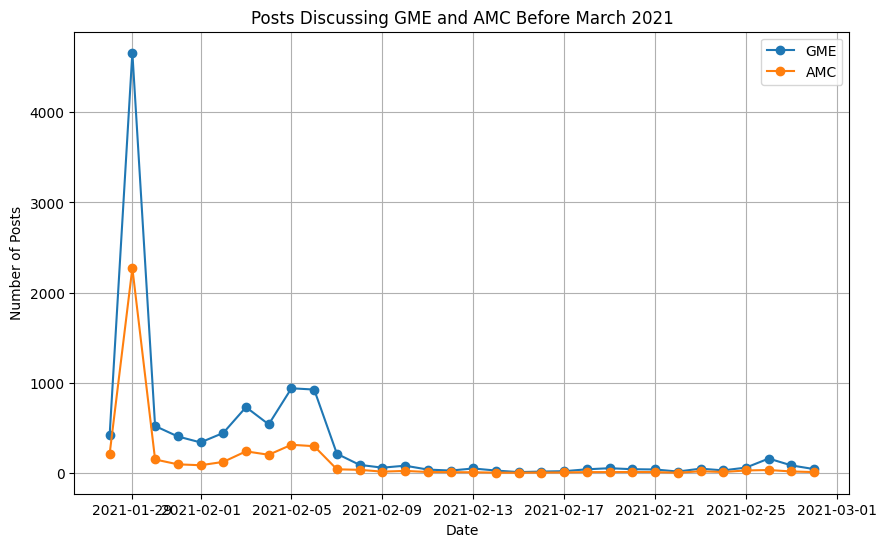

In [102]:
# Filter rows before March 2021
start_date = pd.to_datetime('2021-03-01').date()
gme_counts_before_march = gme_counts[gme_counts.index < start_date]
amc_counts_before_march = amc_counts[amc_counts.index < start_date]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(gme_counts_before_march.index, gme_counts_before_march.values, label='GME', marker='o')
plt.plot(amc_counts_before_march.index, amc_counts_before_march.values, label='AMC', marker='o')

# Formatting
plt.title('Posts Discussing GME and AMC Before March 2021')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend()
plt.grid(True)
plt.show()

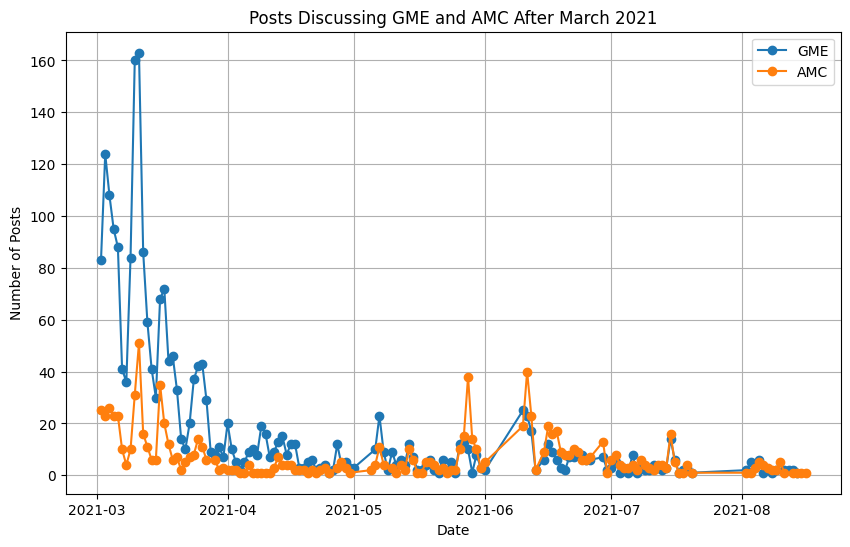

In [103]:
# Filter rows before March 2021
start_date = pd.to_datetime('2021-03-01').date()
gme_counts_after_march = gme_counts[gme_counts.index > start_date]
amc_counts_after_march = amc_counts[amc_counts.index > start_date]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(gme_counts_after_march.index, gme_counts_after_march.values, label='GME', marker='o')
plt.plot(amc_counts_after_march.index, amc_counts_after_march.values, label='AMC', marker='o')

# Formatting
plt.title('Posts Discussing GME and AMC After March 2021')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend()
plt.grid(True)
plt.show()

We can see hype around these stocks spiked in late January of 2021 with over 6000 combined posts. By April discussions had slowed to below 40 combined posts

## Sentiment Analysis

In [ ]:
# Text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)